In [1]:
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer

In [2]:
# https://people.rit.edu/fa3019/technical/aircraft.html
data = pd.read_csv("Aircraft_Annotation_DataFile.csv")

In [3]:
data['PROBLEM']

0                     ENGINE IDLE OVERRIDE KILLED ENGINE.
1                     ENGINE IDLE OVERRIDE KILLED ENGINE.
2                     ENGINE IDLE OVERRIDE KILLED ENGINE.
3       HAD ENGINE CHOKE & BRIEFLY LOSE POWER ON DEPAR...
4            #2 & 4 CYL ROCKER COVER GASKETS ARE LEAKING.
                              ...                        
6164                                   #2 INTAKE LEAKING.
6165                       L/H FWD ENGINE BAFFLE CRACKED.
6166    DURING RUN UP, #2 CYL WAS COLD & ENGINE SHOCK ...
6167    DURING RUN UP, #2 CYL WAS COLD & ENGINE SHOCK ...
6168    SAFETY DEPARTMENT WAS NOTIFIED OF POSSIBLE ENG...
Name: PROBLEM, Length: 6169, dtype: object

In [4]:
nlp = spacy.load('en_core_web_sm')
def preprocess_text(sent):
    doc = nlp(sent)
    tokens = [token.text for token in doc]
    filtered = [token.text for token in doc if token.is_stop == False]
    return " ".join(filtered)
data['PREPROCESS_PROBLEM'] = data['PROBLEM'].apply(preprocess_text)

In [5]:
data

,IDENT,PROBLEM,ACTION,PREPROCESS_PROBLEM
0,100001,ENGINE IDLE OVERRIDE KILLED ENGINE.,"TRIED TO ADJUST IDLE SEVERAL TIMES, WOULDN'T A...",ENGINE IDLE OVERRIDE KILLED ENGINE .
1,100002,ENGINE IDLE OVERRIDE KILLED ENGINE.,REMOVED & REPLACED FUEL SERVO,ENGINE IDLE OVERRIDE KILLED ENGINE .
2,100003,ENGINE IDLE OVERRIDE KILLED ENGINE.,"A/C WAS RUN UP, SET IDLE SPEED, MIXTURE OK, NO...",ENGINE IDLE OVERRIDE KILLED ENGINE .
3,100004,HAD ENGINE CHOKE & BRIEFLY LOSE POWER ON DEPAR...,"PERFORMED ENGINE RUN UP, FOUND CYL 2 LOWER PLU...",ENGINE CHOKE & BRIEFLY LOSE POWER DEPARTURE . THR
4,100005,#2 & 4 CYL ROCKER COVER GASKETS ARE LEAKING.,REMOVED & REPLACED GASKETS.,# 2 & 4 CYL ROCKER COVER GASKETS LEAKING .
...,...,...,...,...
6164,106165,#2 INTAKE LEAKING.,REMOVED & REPLACED INTAKE GASKET.,# 2 INTAKE LEAKING .
6165,106166,L/H FWD ENGINE BAFFLE CRACKED.,STOP DRILLED CRACK.,L / H FWD ENGINE BAFFLE CRACKED .
6166,106167,"DURING RUN UP, #2 CYL WAS COLD & ENGINE SHOCK ...",OPS & LEAK CK GOOD.,"RUN , # 2 CYL COLD & ENGINE SHOCK VIOLENTLY ( ENG"
6167,106168,"DURING RUN UP, #2 CYL WAS COLD & ENGINE SHOCK ...",FOUND #2 CYL EXHAUST VALVE TO BE STUCK. REAMED...,"RUN , # 2 CYL COLD & ENGINE SHOCK VIOLENTLY ( ENG"


# LDA

In [6]:
import pandas as pd

# sklearn - count vectorizers
from sklearn.feature_extraction.text import CountVectorizer

# LDA
from sklearn.decomposition import LatentDirichletAllocation

# Numpy
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

%matplotlib inline


In [7]:
tf_vectorizer = CountVectorizer(decode_error='ignore', max_df = 0.95,min_df=2,stop_words='english') 
tf = tf_vectorizer.fit_transform(data['PREPROCESS_PROBLEM'])

In [8]:
lda = LatentDirichletAllocation(n_components = 5, max_iter=5, learning_method='online',learning_offset=50., random_state=0)

lda.fit(tf)

# making LDA TOP MATRIX USING CORPUS TF
lda_topic_modelling = lda.fit_transform(tf)

In [9]:
def get_top_n_words(n, keys, document_term_matrix, cv):
    top_word_indices = []
    n_topics=5

    for topic in range(n_topics): # go from 0 to 24
        temp_vector_sum = 0
        
        for i in range(len(keys)): # go from 0 to 20971
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        
        
        temp_vector_sum = temp_vector_sum.toarray()


        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)  


    top_words = []
    for topic in top_word_indices:
        topic_words = []

        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            # print(temp_word_vector)
            
            the_word = cv.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

def get_keys(topic_matrix):
  # print(topic_matrix.argmax(axis = 1)) # axis = 1, will return maximum index in that array 
    keys = topic_matrix.argmax(axis = 1).tolist()
    print("length of the keys is: ",len(keys))
    return keys

In [10]:
n_top_words = 25
lda_keys = get_keys(lda_topic_modelling)
top_n_words = get_top_n_words(n_top_words, lda_keys, tf, tf_vectorizer)

length of the keys is:  6169


In [11]:
for i in range(len(top_n_words)):
    print("Topic {}: \n".format(i+1), top_n_words[i]+"\n")

Topic 1: 
 baffle engine broken needs aft cyl oil rod cracked bracket tie rivets sheared removed replaced rivet wire repair eng spring support loose facilitate changed dirty

Topic 2: 
 baffle engine cyl loose cracked seal eng oil missing fwd screw worn plug aft plugs cooler rear crack baffling intake bolt cylinder needs tube line

Topic 3: 
 leaking rocker cover engine gaskets gasket cyl intake intakes covers eng box loose screws leaks missing screw leak cylinder torn lines shaft oil valve seeping

Topic 4: 
 leaking intake gasket cyl eng compression tube low gaskets cylinder engine induction 80 exhaust leaks push rod valve sump loose hose seal crankshaft clamps oil

Topic 5: 
 engine rpm rough start run running cyl flight idle ran power eng prop mag vibration started failed overspeed throttle valve requires high ck required assist



# Corex

In [12]:
from corextopic import corextopic as ct

In [13]:
topic_model = ct.Corex(n_hidden=10)  # Define the number of latent (hidden) topics to use.
topic_model.fit(tf, words=tf_vectorizer.get_feature_names_out())

In [14]:
topics = topic_model.get_topics()
for topic_n,topic in enumerate(topics):
    # w: word, mi: mutual information, s: sign
    topic = [(w,mi,s) for w,mi,s in topic]
    # Unpack the info about the topic
    words,mis,signs = zip(*topic)    
    # Print topic
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)

1: leaking, rocker, intake, gasket, cover, gaskets, intakes, covers, start, prop
2: baffle, cracked, missing, aft, fwd, seal, screw, worn, plug, loose
3: rpm, rough, run, running, idle, ran, power, started, repair, overspeed
4: oil, needs, cooler, line, removed, return, hose, clamps, drain, leak
5: compression, low, 80, push, cylinder, rod, 40, psi, 20, 35
6: valve, exhaust, failed, flight, vibration, required, change, stuck, strike, felt
7: pilot, adel, clamp, noted, pump, requested, vacuum, reported, overhaul, plate
8: eng, engine, tube, induction, damage, appears, rods, tac, marks, blocked
9: box, screws, air, filter, cowl, heat, inlet, carb, need, shock
10: cyl, connection, dead, pipe, extending, nutplate, staple, tension, connector, brackets


In [15]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text2(sent):
    doc = nlp(sent)
    filtered = [token.lemma_ for token in doc if (token.pos_ in ("NOUN", "VERB")) & (token.is_stop == False)]
    return " ".join(filtered)

In [16]:
data['PREPROCESS_PROBLEM2'] = data['PROBLEM'].apply(lambda x: preprocess_text2(x))

In [17]:
tf_vectorizer = CountVectorizer(decode_error='ignore', max_df = 0.95,min_df=2,stop_words='english') # applying count vectorizer
# print(tf_vectorizer)
tf = tf_vectorizer.fit_transform(data['PREPROCESS_PROBLEM2'])

## Unsupervised

In [18]:
topic_model = ct.Corex(n_hidden=10)  # Define the number of latent (hidden) topics to use.
topic_model.fit(tf, words=tf_vectorizer.get_feature_names_out())

In [19]:
topics = topic_model.get_topics()
for topic_n,topic in enumerate(topics):
    # w: word, mi: mutual information, s: sign
    topic = [(w,mi,s) for w,mi,s in topic]
    # Unpack the info about the topic
    words,mis,signs = zip(*topic)    
    # Print topic
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)

1: engine, rpm, run, leak, ran, rough, requires, roughness, flight, landing
2: leaking, gasket, intake, tube, aft, fail, rear, intakes, come, note
3: need, push, needs, replaced, seal, cowl, change, cleaned, clamp, appear
4: crack, baffling, fuel, oil, line, connect, cooler, support, request, cool
5: cylinder, miss, valve, exhaust, rivets, head, area, cyl, screws, clearance
6: cracked, bracket, chafing, baffle, place, wire
7: start, begin, hit, standby, rich, lace, anchor, lines
8: compression, rocker, low, zero, shaft, starter, play
9: vibration, hardware, test, crankshaft, evidence, running, hold, portion
10: return, teeth, ring, plug, safety


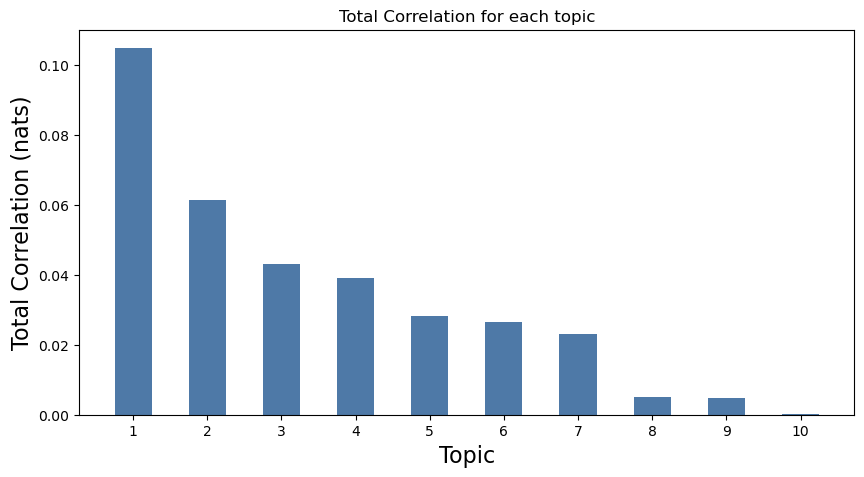

In [123]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.title("Total Correlation for each topic")
_= plt.xticks(range(10), range(1,11))

In [171]:
tc_list = []
for i in range(1, 15):
    topic_model = ct.Corex(n_hidden=i)  # Define the number of latent (hidden) topics to use.
    topic_model.fit(tf, words=tf_vectorizer.get_feature_names_out())
    tc_list.append(topic_model.tc)

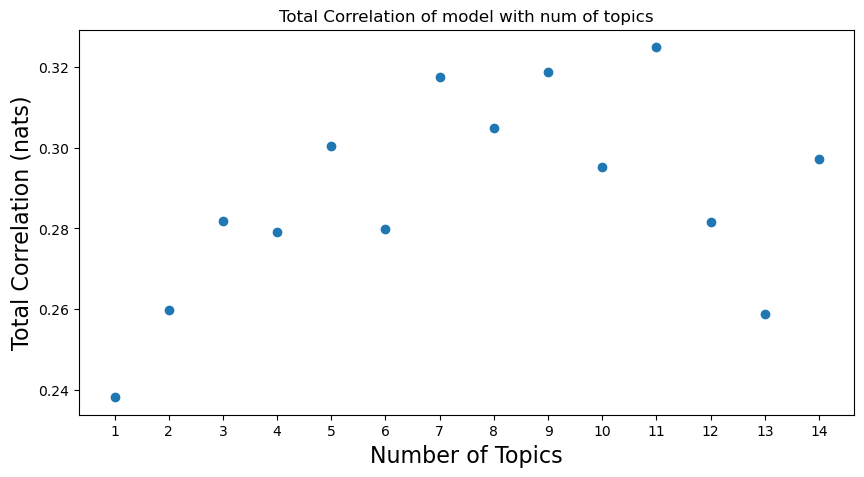

In [174]:
plt.figure(figsize=(10,5))
plt.scatter(range(1,15), tc_list)
plt.xlabel('Number of Topics', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.title("Total Correlation of model with num of topics")
_= plt.xticks(range(1,15), range(1,15))

## Supervision

In [173]:
anchors=[['engine', 'run'], ['gasket', 'leak'], 
         ['replaced', 'seal'],  ['crack', 'cylinder', 'exhaust'], ['sump', 'leak']]
topic_model = ct.Corex(n_hidden=7)  # Define the number of latent (hidden) topics to use.
topic_model.fit(tf, words=tf_vectorizer.get_feature_names_out(), anchors=anchors)



In [137]:
topics = topic_model.get_topics()
for topic_n,topic in enumerate(topics):
    # w: word, mi: mutual information, s: sign
    topic = [(w,mi,s) for w,mi,s in topic]
    # Unpack the info about the topic
    words,mis,signs = zip(*topic)    
    # Print topic
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)

1: engine, rpm, run, start, ran, rough, roughness, requires, perform, flight
2: leaking, gasket, intake, tube, aft, fail, rear, intakes, miss, leak
3: seal, need, needs, replaced, push, cowl, change, fuel, cleaned, appear
4: cracked, baffling, cylinder, crack, cyl, connect, compression, pressure, cool, psi
5: leak, cover, rocker, point, attachment, sump, evidence, puddle
6: line, return, reach, added, repositioned, washer, standby, possible, starter, anchor
7: oil, support, rivets, head, area, stop, breather, hit, flange, clearance


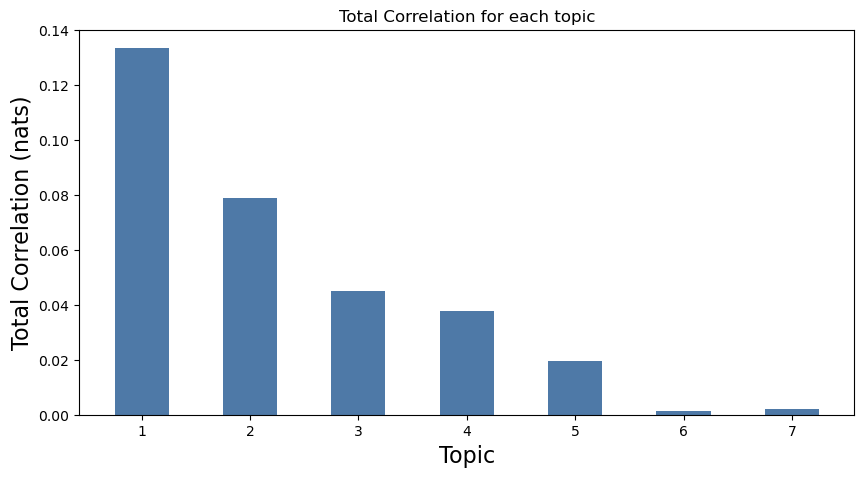

In [138]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.title("Total Correlation for each topic")
_= plt.xticks(ticks=range(7), labels=range(1, 8))